MLEnKF surprisingly easy to implement, we deal with one dimension case first, let's use varphi(x)=x

In [ ]:
One dimmensional Data generator: Expected to output a sequence of observations of the highest frequency lmax=12

In [138]:
## First we deal the one dimensional case
import numpy as np
import math
from scipy.stats import norm
## Initialization
T = 100
lmax = 12
l = lmax
## dimension value, redundant for one dimensional case but useful for high dimension
d = 1
dtim = 2**l*T
dt = 2**(-l)
A = 0.11 
C = 0.01
R1 = 1
R2 = 1
## initial mean m, initial covariance C
m = 1
c = 1
## Data vector
y = np.zeros(dtim+1)
## Signal vector
x = np.zeros(dtim+1)
## I will just discretized the model to get the data as it's the most straight forwrd ways
y[0] = 0
x[0] = np.random.normal(m,math.sqrt(c),1)
for t in range(dtim):
    dw = np.random.normal(0,math.sqrt(dt),d)
    dv = np.random.normal(0,math.sqrt(dt),d)
    y[t+1] = y[t] + C*x[t]*dt + np.sqrt(R2)*dv
    x[t+1] = x[t] + A*x[t]*dt + np.sqrt(R1)*dw

Save the one dimensional data here 

In [117]:
np.savetxt("data1d.csv", y, delimiter=",")

Load the data here

In [10]:
import numpy as np
import math
from scipy.stats import norm
lmax = 12
y = np.loadtxt('data1d.csv')

Ensemble Kalman Bucy Filter on a single level

In [195]:
def EKBF(T,l,N):
    d = 1
    dtim = 2**l*T
    dt = 2**(-l)
    A = 0.11 
    C = 0.01
    R1 = 1
    R2 = 1
    ## initial mean m, initial covariance C
    m = 1
    c = 1
    ## Vlasov diffusion signal
    x = np.zeros(N)
    x = np.random.normal(m,np.sqrt(c),N)
    for t in range(dtim):
        dw = np.random.normal(0,math.sqrt(dt),N)
        dv = np.random.normal(0,math.sqrt(dt),N)
        mean = np.mean(x)
        ## This doesn't have to be calculated out in high dimension, to my understanding
        ## Basically explicitly computing this p matrix in high dimension is gonna be a nightmare, however
        ## a nice form of H would significantly reduces the amount of work required for computing p*C straight away
        p = (N-1)**(-1)*np.sum((x-mean)*(x-mean))
        x = x + A*x*dt + R1*dw + p*C*R2**(-2)*( (y[(t+1)*2**(lmax-l)]-y[t*2**(lmax-l)]) - (C*x*dt + R2*dv) )
    return np.mean(x)

Coupled Ensemble Kalman Bucy Filter

In [196]:
## Coupled Ensemble Kalman Bucy Filter
def CEKBF(T,l,N):
    d = 1
    # ctim = dtim/2
    dtim = 2**l*T
    ctim = 2**(l-1)*T
    dt = 2**(-l)
    A = 0.11 
    C = 0.01
    R1 = 1
    R2 = 1
    ## initial mean m, initial covariance C
    m = 1
    c = 1
    ## Vlasov diffusion signal
    xf = np.zeros(N)
    xc = np.zeros(N)
    ## Initialize signal
    xf = np.random.normal(m,c,N)
    xc = xf
    for t in range(ctim):
        dw = np.sqrt(dt)*np.random.randn(2,N)
        dv = np.sqrt(dt)*np.random.randn(2,N)
        mf = np.mean(xf)
        mc = np.mean(xc)
        ## Yes I am storing it again and I shouldn't be doing that I know but it's one-dimension case
        pf = (N-1)**(-1)*np.sum((xf-mf)*(xf-mf))
        pc = (N-1)**(-1)*np.sum((xc-mc)*(xc-mc))
        for s in range(2):
            xf = xf + A*xf*dt + R1*dw[s,] + pf*C*R2**(-2)*( (y[(t*2+s+1)*2**(lmax-l)]-y[(t*2+s)*2**(lmax-l)]) - (C*xf*dt + R2*dv[s,]) )
        xc = xc + A*xc*(dt*2) + R1*(dw[0,]+dw[1,]) + pc*C*R2**(-2)*( y[(t+1)*2**(lmax-l+1)]-y[(t)*2**(lmax-l+1)] - (C*xc*(dt*2) + R2*(dv[0,]+dv[1,])) )
    return (np.mean(xf) - np.mean(xc))

Kalman Bucy Filter as reference

In [197]:
def KBF(T,l):
    ndim = T*2**(l)
    tau = 2**(-l)
    ## tau / 2**(-lmax)
    rtau = 2**(-l+lmax)
    A = 0.11 
    ## Danger, here C is the parameter matrix, while below c represent the analysis covariance matrix, first bug uses same expression C for both
    C = 0.01
    R1 = 1
    R2 = 1
    ## initial mean m, initial covariance c
    m = 1
    c = 1
    ## Bunch of calculation of variance
    W = (np.exp(2*A*tau)-1)/(2*A)
    L = np.exp(A*tau)
    H = C*tau
    V = tau

    for n in range(ndim):
        ## prediction
        mhat = L*m
        chat = L*c*L + W
        ## Kalman Gain
        K = chat*H*(H*mhat*H + V)**(-1)
        ## update/analysis
        m = mhat + K*(y[(n+1)*rtau]-y[n*rtau] - H*chat)
        c = (1-K*H)*chat
    return(m)

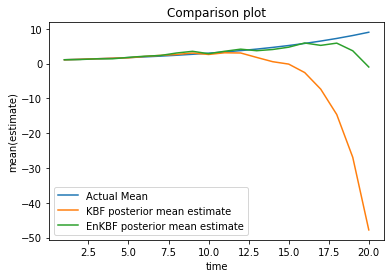

<Figure size 432x288 with 0 Axes>

In [208]:
import matplotlib.pyplot as plt
## Actual mean E[X_t]
x1 = np.arange(1,21)
y1 = np.exp(x1*A)
# plotting 
plt.plot(x1, y1, label = "Actual Mean")
## Approx posterior mean by Kalman-Bucy Filter at discretization level 8
x2 = x1
y2 = np.zeros(20)
for i in range(20):
    y2[i] = KBF(x2[i],8)
# plotting
plt.plot(x2, y2, label = "KBF posterior mean estimate")
## Approx empirical posterior mean by Ensemble Kalman-Bucy Filter at discretization level 8 wtih 1000 ensembles
x3 = x1
y3 = np.zeros(20)
for i in range(20):
    y3[i] =EKBF(x3[i],8,1000)
## plotting
plt.plot(x3, y3, label = "EnKBF posterior mean estimate")
##
plt.xlabel('time')
plt.ylabel('mean(estimate)')
plt.title('Comparison plot')
plt.legend()
plt.show()